<center><h2>ALTeGraD 2024<br> HAN</h2><h3>Hierarchical Attention Network Using GRU</h3> <br>



</center>
In this lab, we get familiar with recurrent neural networks (RNNs), self-attention, and the HAN architecture <b>(Yang et al. 2016)</b> using PyTorch. In this architecture, sentence embeddings are first individually produced, and a document embedding is then computed from the sentence embeddings.<br>

### = = = = =  Attention Layer = = = = =
In this section, we implement the self-attention layer. This layer will be used later to define the HAN architecture. The basic idea behind attention is that rather than considering the last annotation $h_T$ as a summary of the entire sequence, which is prone to information loss, the annotations at <i>all</i> time steps are used.
The self-attention mechanism computes a weighted sum of the annotations, where the weights are determined by trainable parameters.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader


class AttentionWithContext(nn.Module):
    """
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    """

    def __init__(self, input_shape, return_coefficients=False, bias=True):
        super(AttentionWithContext, self).__init__()
        self.return_coefficients = return_coefficients

        self.W = nn.Linear(input_shape, input_shape, bias=bias)
        self.tanh = nn.Tanh()
        self.u = nn.Linear(input_shape, 1, bias=False)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.W.weight.data.uniform_(-initrange, initrange)
        self.W.bias.data.uniform_(-initrange, initrange)
        self.u.weight.data.uniform_(-initrange, initrange)

    def generate_square_subsequent_mask(self, sz):
        # do not pass the mask to the next layers
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def forward(self, x, mask=None):
        uit = self.W(x)
        uit = self.tanh(uit)
        ait = self.u(uit)
        a = torch.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            a = a * mask.double()

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        eps = 1e-9
        a = a / (torch.sum(a, axis=1, keepdim=True) + eps)
        weighted_input = torch.sum(
            a * x, axis=1
        )  # compute the attentional vector: (samples, features, 1)

        if self.return_coefficients:
            return [
                weighted_input,
                a,
            ]
        else:
            return weighted_input

### = = = = = Parameters = = = = =
In this section, we define the parameters to use in our training. Such as data path, the embedding dimention <b>d</b>, the GRU layer dimensionality <b>n_units</b>, etc..<br>
The parameter <b>device</b> is used to train the model on GPU if it is available.

In [6]:
import sys
import json
import operator
import numpy as np

path_root = ""
path_to_data = path_root + "data/"

d = 30  # dimensionality of word embeddings
n_units = 50  # RNN layer dimensionality
drop_rate = 0.5  # dropout
mfw_idx = 2  # index of the most frequent words in the dictionary
# 0 is for the special padding token
# 1 is for the special out-of-vocabulary token

padding_idx = 0
oov_idx = 1
batch_size = 64
nb_epochs = 15
my_patience = 2  # for early stopping strategy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### = = = = = Data Loading = = = = =
In this section we use first <b>wget</b> to download the data. Then we will load it using numpy in the first cell. While in the second cell, we will use these data to define our Pytorch data loader. Note that the data is already preprocessed, tokenized and padded.<br><br>

In [7]:
# import urllib.request
# url = "https://onedrive.live.com/download?cid=AE69638675180117&resid=AE69638675180117%2199289&authkey=AHgxt3xmgG0Fu5A"
# output_file = "data.zip"
# urllib.request.urlretrieve(url, output_file)

# !unzip data.zip

my_docs_array_train = np.load(path_to_data + "docs_train.npy")
my_docs_array_test = np.load(path_to_data + "docs_test.npy")

my_labels_array_train = np.load(path_to_data + "labels_train.npy")
my_labels_array_test = np.load(path_to_data + "labels_test.npy")

# load dictionary of word indexes (sorted by decreasing frequency across the corpus)
with open(path_to_data + "word_to_index.json", "r") as my_file:
    word_to_index = json.load(my_file)

# invert mapping
index_to_word = {i: word for word, i in word_to_index.items()}
input_size = my_docs_array_train.shape
print(input_size)

(25000, 7, 30)


In [8]:
import numpy
import torch
from torch.utils.data import DataLoader, Dataset


class Dataset_(Dataset):
    def __init__(self, x, y):
        self.documents = x
        self.labels = y

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        document = self.documents[index]
        label = self.labels[index]
        sample = {
            "document": torch.tensor(document),
            "label": torch.tensor(label),
        }
        return sample


def get_loader(x, y, batch_size=32):
    dataset = Dataset_(x, y)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

### = = = = = Defining Architecture = = = = =
In this section, we define the HAN architecture. We start with <i>AttentionBiGRU</i> module in order to define the sentence encoder. Then, we define the <i>TimeDistributed</i> module to allow us to forward our input (batch of document) as to the sentence encoder as <b>batch of sentences</b>, where each sentence in the document will be considered as a time step. This module also reshape the output to a batch of timesteps representations per document. Finally we define the <b>HAN</b> architecture using <i>TimeDistributed</i>, <i>AttentionWithContext</i> and <i>GRU</i>.

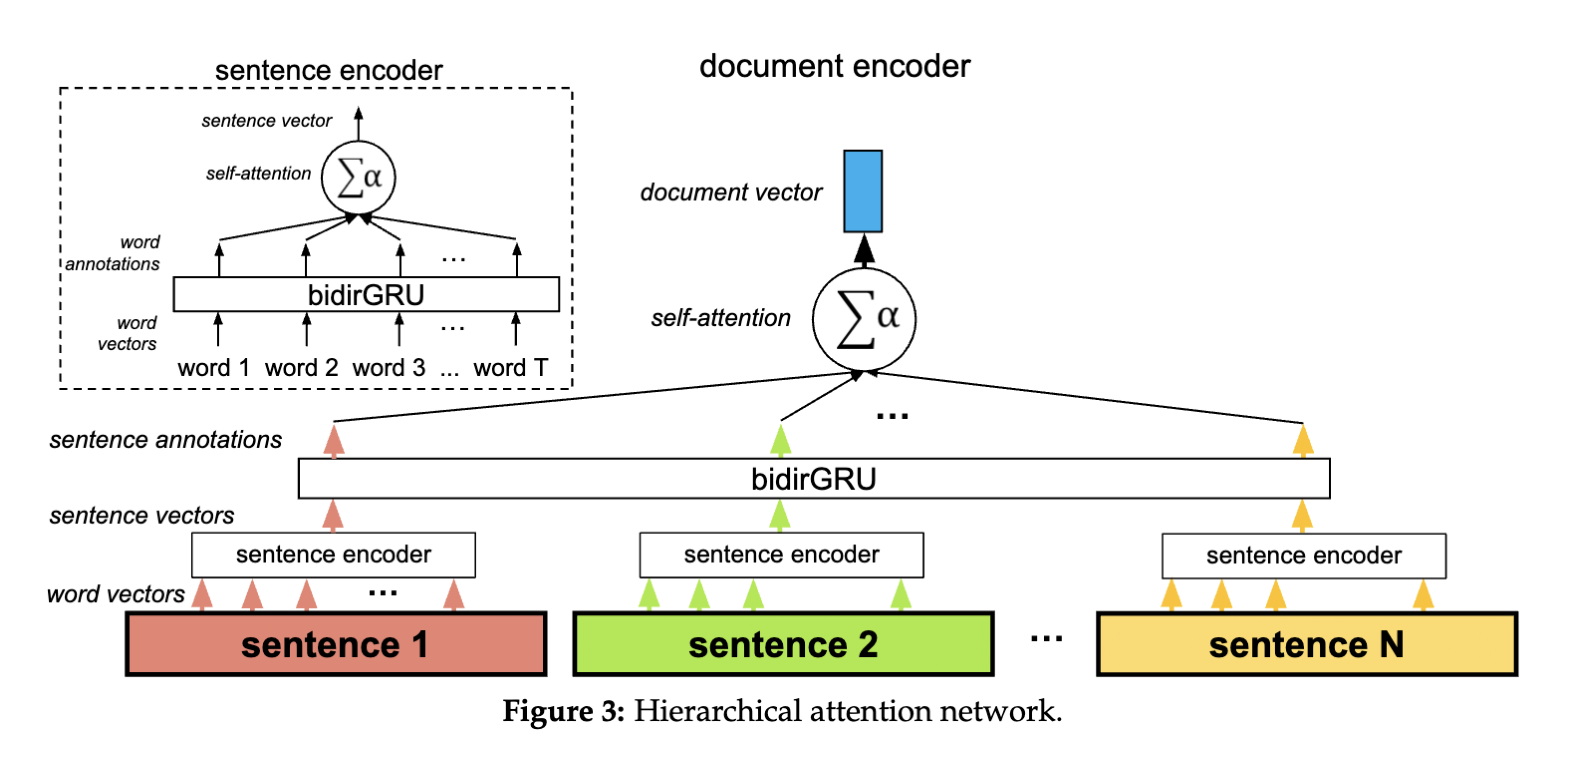

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Charger et afficher une image
plt.figure(figsize=(20, 20))
img = mpimg.imread("Screenshot 2024-10-13 at 21.57.31.png")
imgplot = plt.imshow(img)

# Don't display the axes
plt.axis("off")
plt.show()

In [9]:
class AttentionBiGRU(nn.Module):
    def __init__(self, input_shape, n_units, index_to_word, dropout=0):
        super(AttentionBiGRU, self).__init__()
        self.embedding = nn.Embedding(len(index_to_word) + 2, d, padding_idx=0)
        self.dropout = nn.Dropout(drop_rate)
        self.gru = nn.GRU(
            input_size=d,
            hidden_size=n_units,
            num_layers=1,
            bias=True,
            batch_first=True,
            bidirectional=True,
        )
        self.attention = AttentionWithContext(2 * n_units, return_coefficients=True)

    def forward(self, sent_ints):
        sent_wv = self.embedding(sent_ints)

        sent_wv_dr = self.dropout(sent_wv)
        sent_wa, _ = self.gru(sent_wv_dr)
        sent_att_vec, word_att_coeffs = self.attention(sent_wa)
        sent_att_vec_dr = self.dropout(sent_att_vec)
        return sent_att_vec_dr, word_att_coeffs


class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(
            -1, x.size(-1)
        )  # (samples * timesteps, input_size) (448, 30)
        sent_att_vec_dr, word_att_coeffs = self.module(x_reshape)
        # We have to reshape the output
        if self.batch_first:
            sent_att_vec_dr = sent_att_vec_dr.contiguous().view(
                x.size(0), -1, sent_att_vec_dr.size(-1)
            )  # (samples, timesteps, output_size)
            word_att_coeffs = word_att_coeffs.contiguous().view(
                x.size(0), -1, word_att_coeffs.size(-1)
            )  # (samples, timesteps, output_size)
        else:
            sent_att_vec_dr = sent_att_vec_dr.view(
                -1, x.size(1), sent_att_vec_dr.size(-1)
            )  # (timesteps, samples, output_size)
            word_att_coeffs = word_att_coeffs.view(
                -1, x.size(1), word_att_coeffs.size(-1)
            )  # (timesteps, samples, output_size)
        return sent_att_vec_dr, word_att_coeffs


class HAN(nn.Module):
    def __init__(self, input_shape, n_units, index_to_word, dropout=0):
        super(HAN, self).__init__()
        self.encoder = AttentionBiGRU(input_shape, n_units, index_to_word, dropout)
        self.timeDistributed = TimeDistributed(self.encoder, True)
        self.dropout = nn.Dropout(drop_rate)
        self.gru = nn.GRU(
            input_size=2 * n_units,
            hidden_size=n_units,
            num_layers=1,
            bias=True,
            batch_first=True,
            bidirectional=True,
        )

        self.attention = AttentionWithContext(
            input_shape=2 * n_units, return_coefficients=True
        )
        self.lin_out = nn.Linear(2 * n_units, 1)

        self.preds = nn.Sigmoid()

    def forward(self, doc_ints):
        sent_att_vecs_dr, word_att_coeffs = self.timeDistributed(doc_ints)
        doc_sa, _ = self.gru(sent_att_vecs_dr)
        doc_att_vec, sent_att_coeffs = self.attention(doc_sa)
        doc_att_vec_dr = self.dropout(doc_att_vec)
        doc_att_vec_dr = self.lin_out(doc_att_vec_dr)
        return self.preds(doc_att_vec_dr), word_att_coeffs, sent_att_coeffs

### = = = = = Training = = = = =
In this section, we have two code cells. In the first one, we define our evaluation function to compute the training and validation accuracies. While in the second one, we define our model, loss and optimizer and train the model over <i>nb_epochs</i>.<br>

In [10]:
def evaluate_accuracy(data_loader, verbose=True):
    model.eval()
    total_loss = 0.0
    ncorrect = ntotal = 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            # inference
            output = model(data["document"].to(device))[0]
            output = output[:, -1]  # only last vector
            # total number of examples
            ntotal += output.shape[0]
            # number of correct predictions
            predictions = torch.round(output)
            ncorrect += len(predictions) - torch.sum(
                torch.abs(data["label"].to(device) - predictions)
            )  # fill me # number of correct prediction - hint: use torch.sum
        acc = ncorrect.item() / ntotal
        if verbose:
            print("validation accuracy: {:3.2f}".format(acc * 100))
        return acc

In [11]:
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()


model = HAN(input_size, n_units, index_to_word).to(device)
model = model.double()
lr = 0.001  # learning rate
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def train(
    x_train=my_docs_array_train,
    y_train=my_labels_array_train,
    x_test=my_docs_array_test,
    y_test=my_labels_array_test,
    word_dict=index_to_word,
    batch_size=batch_size,
):

    train_data = get_loader(x_train, y_train, batch_size)
    test_data = get_loader(x_test, y_test, batch_size)

    best_validation_acc = 0.0
    p = 0  # patience

    for epoch in range(1, nb_epochs + 1):
        losses = []
        accuracies = []
        with tqdm(train_data, unit="batch") as tepoch:
            for idx, data in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch}")
                model.train()
                optimizer.zero_grad()
                input = data["document"].to(device)
                label = data["label"].to(device)
                label = label.double()
                output = model.forward(input)[0]
                output = output[:, -1]
                loss = criterion(output, label)
                writer.add_scalar("Loss/train", loss, epoch)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), 0.5
                )  # prevent exploding gradient
                optimizer.step()

                losses.append(loss.item())
                accuracy = torch.sum(torch.round(output) == label).item() / batch_size
                accuracies.append(accuracy)
                tepoch.set_postfix(
                    loss=sum(losses) / len(losses),
                    accuracy=100.0 * sum(accuracies) / len(accuracies),
                )

        # train_acc = evaluate_accuracy(train_data, False)
        test_acc = evaluate_accuracy(test_data, False)
        print(
            "===> Epoch {} Complete: Avg. Loss: {:.4f}, Validation Accuracy: {:3.2f}%".format(
                epoch, sum(losses) / len(losses), 100.0 * test_acc
            )
        )
        if test_acc >= best_validation_acc:
            best_validation_acc = test_acc
            print("Validation accuracy improved, saving model...")
            torch.save(model.state_dict(), "./best_model.pt")
            p = 0
            print()
        else:
            p += 1
            if p == my_patience:
                print(
                    "Validation accuracy did not improve for {} epochs, stopping training...".format(
                        my_patience
                    )
                )
    print("Loading best checkpoint...")
    model.load_state_dict(torch.load("./best_model.pt"))
    model.eval()
    print("done.")


train()

Epoch 1: 100%|██████████| 390/390 [00:55<00:00,  7.09batch/s, accuracy=60.8, loss=0.653]


===> Epoch 1 Complete: Avg. Loss: 0.6530, Validation Accuracy: 70.74%
Validation accuracy improved, saving model...



Epoch 2: 100%|██████████| 390/390 [00:52<00:00,  7.50batch/s, accuracy=70.8, loss=0.567]


===> Epoch 2 Complete: Avg. Loss: 0.5675, Validation Accuracy: 75.95%
Validation accuracy improved, saving model...



Epoch 3: 100%|██████████| 390/390 [00:55<00:00,  6.99batch/s, accuracy=75.4, loss=0.509]


===> Epoch 3 Complete: Avg. Loss: 0.5086, Validation Accuracy: 78.26%
Validation accuracy improved, saving model...



Epoch 4: 100%|██████████| 390/390 [00:51<00:00,  7.52batch/s, accuracy=78.2, loss=0.464]


===> Epoch 4 Complete: Avg. Loss: 0.4644, Validation Accuracy: 80.79%
Validation accuracy improved, saving model...



Epoch 5: 100%|██████████| 390/390 [00:50<00:00,  7.76batch/s, accuracy=80, loss=0.431]  


===> Epoch 5 Complete: Avg. Loss: 0.4312, Validation Accuracy: 81.09%
Validation accuracy improved, saving model...



Epoch 6: 100%|██████████| 390/390 [00:50<00:00,  7.68batch/s, accuracy=81.8, loss=0.404]


===> Epoch 6 Complete: Avg. Loss: 0.4037, Validation Accuracy: 82.74%
Validation accuracy improved, saving model...



Epoch 7: 100%|██████████| 390/390 [00:51<00:00,  7.64batch/s, accuracy=82.8, loss=0.386]


===> Epoch 7 Complete: Avg. Loss: 0.3865, Validation Accuracy: 82.02%


Epoch 8: 100%|██████████| 390/390 [00:51<00:00,  7.51batch/s, accuracy=84, loss=0.365]  


===> Epoch 8 Complete: Avg. Loss: 0.3650, Validation Accuracy: 83.37%
Validation accuracy improved, saving model...



Epoch 9: 100%|██████████| 390/390 [00:50<00:00,  7.69batch/s, accuracy=84.8, loss=0.349]


===> Epoch 9 Complete: Avg. Loss: 0.3490, Validation Accuracy: 82.52%


Epoch 10: 100%|██████████| 390/390 [00:52<00:00,  7.46batch/s, accuracy=85.7, loss=0.331]


===> Epoch 10 Complete: Avg. Loss: 0.3311, Validation Accuracy: 84.43%
Validation accuracy improved, saving model...



Epoch 11: 100%|██████████| 390/390 [00:53<00:00,  7.24batch/s, accuracy=86.4, loss=0.318]


===> Epoch 11 Complete: Avg. Loss: 0.3179, Validation Accuracy: 83.66%


Epoch 12: 100%|██████████| 390/390 [00:52<00:00,  7.39batch/s, accuracy=87.2, loss=0.303]


===> Epoch 12 Complete: Avg. Loss: 0.3033, Validation Accuracy: 84.01%
Validation accuracy did not improve for 2 epochs, stopping training...


Epoch 13: 100%|██████████| 390/390 [00:53<00:00,  7.30batch/s, accuracy=87.7, loss=0.292]


===> Epoch 13 Complete: Avg. Loss: 0.2920, Validation Accuracy: 84.38%


Epoch 14: 100%|██████████| 390/390 [00:51<00:00,  7.54batch/s, accuracy=88.4, loss=0.28] 


===> Epoch 14 Complete: Avg. Loss: 0.2803, Validation Accuracy: 84.64%
Validation accuracy improved, saving model...



Epoch 15: 100%|██████████| 390/390 [00:52<00:00,  7.42batch/s, accuracy=88.8, loss=0.271]


===> Epoch 15 Complete: Avg. Loss: 0.2710, Validation Accuracy: 84.38%
Loading best checkpoint...
done.


In [6]:
model = HAN(input_size, n_units, index_to_word).to(device)
model = model.double()
model.load_state_dict(torch.load("./best_model.pt"))
model.eval()

HAN(
  (encoder): AttentionBiGRU(
    (embedding): Embedding(29938, 30, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(30, 50, batch_first=True, bidirectional=True)
    (attention): AttentionWithContext(
      (W): Linear(in_features=100, out_features=100, bias=True)
      (tanh): Tanh()
      (u): Linear(in_features=100, out_features=1, bias=False)
    )
  )
  (timeDistributed): TimeDistributed(
    (module): AttentionBiGRU(
      (embedding): Embedding(29938, 30, padding_idx=0)
      (dropout): Dropout(p=0.5, inplace=False)
      (gru): GRU(30, 50, batch_first=True, bidirectional=True)
      (attention): AttentionWithContext(
        (W): Linear(in_features=100, out_features=100, bias=True)
        (tanh): Tanh()
        (u): Linear(in_features=100, out_features=1, bias=False)
      )
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (attention): AttentionWithContext(
    (W): Linear(in_featu

### = = = = = Extraction of Attention Coefficients = = = = =
In this section, we will extract and display the attention coefficients on two levels: sentence level and word level. To do so, we will extract the corresponding weights from our model.

In [12]:
# select last review:
my_review = my_docs_array_test[-10000, :, :]
my_review = my_review.reshape(1, my_review.shape[0], my_review.shape[1])
# convert integer review to text:
index_to_word[1] = "OOV"
my_review_text = [
    [index_to_word[idx] for idx in sent if idx in index_to_word]
    for sent in my_review.tolist()[0]
]

###   &emsp;&emsp;  = = = = = Attention Over Sentences in the Document = = = = =

In [13]:
my_review_tensor = torch.tensor(my_review).to(device)
preds, word_att_coeffs, sent_coeffs = model.forward(my_review_tensor)
sent_coeffs = sent_coeffs[0, :, :]

for elt in zip(sent_coeffs[:, 0].tolist(), [" ".join(elt) for elt in my_review_text]):
    print(round(elt[0] * 100, 2), elt[1])

11.22 Probably because this is Columbia 's first film in color , the colors look different specially in the indoor scenes .
5.68 They seem to be stronger , sharper and the result is a bit unrealistic , but very pleasing .
17.64 Randolph Scott is the sheriff , a good guy but the real star of the movie is a very young Glenn Ford , who is an outlaw that wants to
13.08 Evelyn Keyes is the woman that starts falling for Ford and Claire Trevor is the Countess that runs the saloon .
18.82 There is a funny character called Nitro that does not think twice before blowing it .
15.34 I particularly enjoyed two moments of the film , one when there is a tremendous horse stampede and you see thousands of horses , there was no computer to help
18.22 Another moment is the final shootout , technically very good .


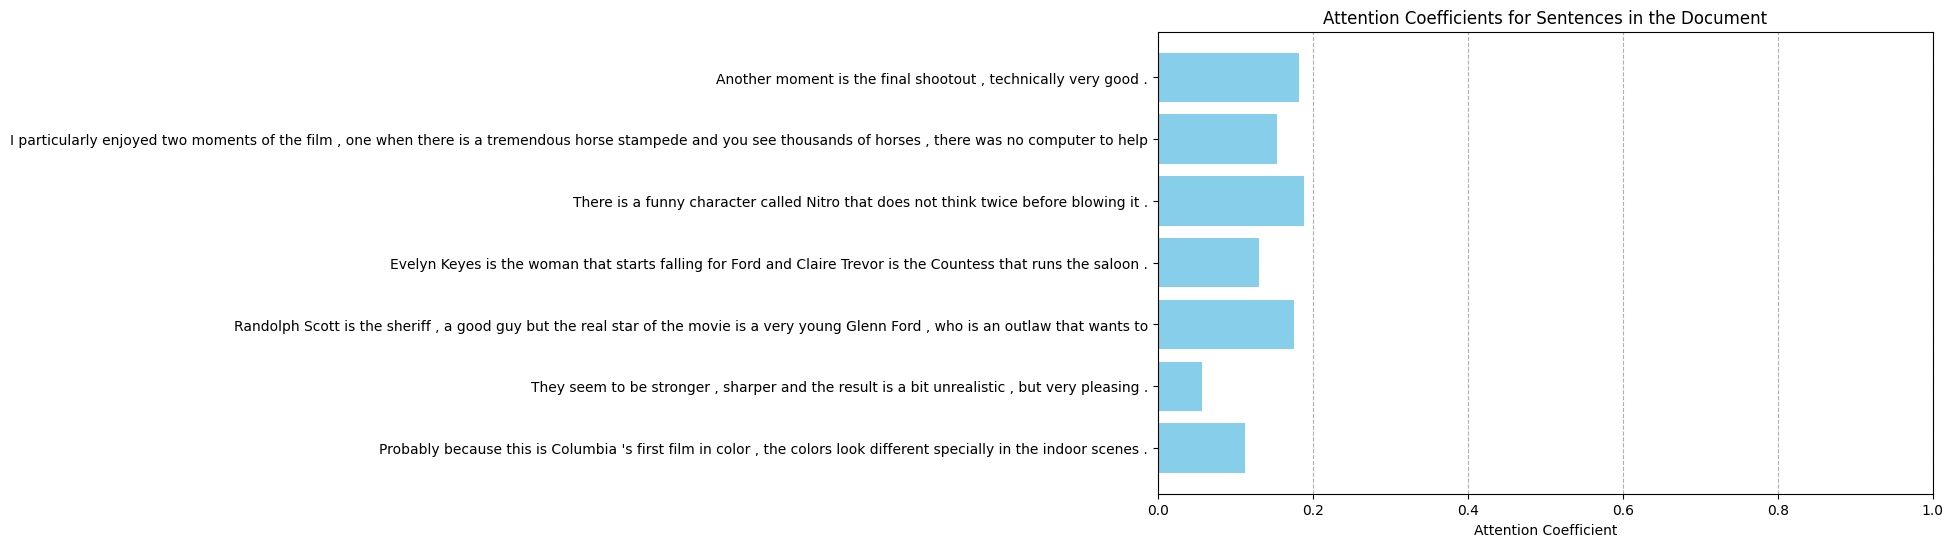

In [14]:
import matplotlib.pyplot as plt
import numpy as np


# Prepare the data for plotting
attention_values = (
    sent_coeffs[:, 0].detach().cpu().numpy()
)  # Move to CPU and convert to numpy array
sentences = [" ".join(elt) for elt in my_review_text]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(sentences)), attention_values, align="center", color="skyblue")
plt.yticks(np.arange(len(sentences)), sentences)
plt.xlabel("Attention Coefficient")
plt.title("Attention Coefficients for Sentences in the Document")
plt.xlim(0, 1)  # Adjust x-axis limits for better visibility
plt.grid(axis="x", linestyle="--")
plt.show()

### &emsp;&emsp; = = = = = Attention Over Words in Each Sentence = = = = =

In [15]:
word_coeffs = word_att_coeffs
word_coeffs_list = word_coeffs.reshape(7, 30).tolist()

# match text and coefficients:
text_word_coeffs = [
    list(zip(words, word_coeffs_list[idx][: len(words)]))
    for idx, words in enumerate(my_review_text)
]

for sent in text_word_coeffs:
    [print(elt) for elt in sent]
    print("= = = =")

# sort words by importance within each sentence:
text_word_coeffs_sorted = [
    sorted(elt, key=operator.itemgetter(1), reverse=True) for elt in text_word_coeffs
]

for sent in text_word_coeffs_sorted:
    [print(elt) for elt in sent]
    print("= = = =")

('Probably', 0.03987262289345338)
('because', 0.030070628856245497)
('this', 0.030653316174671846)
('is', 0.047155023438656955)
('Columbia', 0.112450264356532)
("'s", 0.08681214567021502)
('first', 0.06385977819137517)
('film', 0.028365438060520793)
('in', 0.020999029114352776)
('color', 0.03849238436958528)
(',', 0.015406610414310563)
('the', 0.014715790546140223)
('colors', 0.025018452240625065)
('look', 0.022399673218203603)
('different', 0.03745121797309325)
('specially', 0.02687525969226657)
('in', 0.020269542352315418)
('the', 0.018345914968988613)
('indoor', 0.037580950675213935)
('scenes', 0.03911874650436141)
('.', 0.023840881347241914)
= = = =
('They', 0.058689481473512606)
('seem', 0.0365259016842757)
('to', 0.019881730778753454)
('be', 0.023772236512905796)
('stronger', 0.056392923058127584)
(',', 0.0177816712491446)
('sharper', 0.017182761026624385)
('and', 0.017666979584360556)
('the', 0.013374448969014973)
('result', 0.04493774067684091)
('is', 0.015291059303752946)
('a'

[[('Probably', 0.03987262289345338), ('because', 0.030070628856245497), ('this', 0.030653316174671846), ('is', 0.047155023438656955), ('Columbia', 0.112450264356532), ("'s", 0.08681214567021502), ('first', 0.06385977819137517), ('film', 0.028365438060520793), ('in', 0.020999029114352776), ('color', 0.03849238436958528), (',', 0.015406610414310563), ('the', 0.014715790546140223), ('colors', 0.025018452240625065), ('look', 0.022399673218203603), ('different', 0.03745121797309325), ('specially', 0.02687525969226657), ('in', 0.020269542352315418), ('the', 0.018345914968988613), ('indoor', 0.037580950675213935), ('scenes', 0.03911874650436141), ('.', 0.023840881347241914)], [('They', 0.058689481473512606), ('seem', 0.0365259016842757), ('to', 0.019881730778753454), ('be', 0.023772236512905796), ('stronger', 0.056392923058127584), (',', 0.0177816712491446), ('sharper', 0.017182761026624385), ('and', 0.017666979584360556), ('the', 0.013374448969014973), ('result', 0.04493774067684091), ('is',

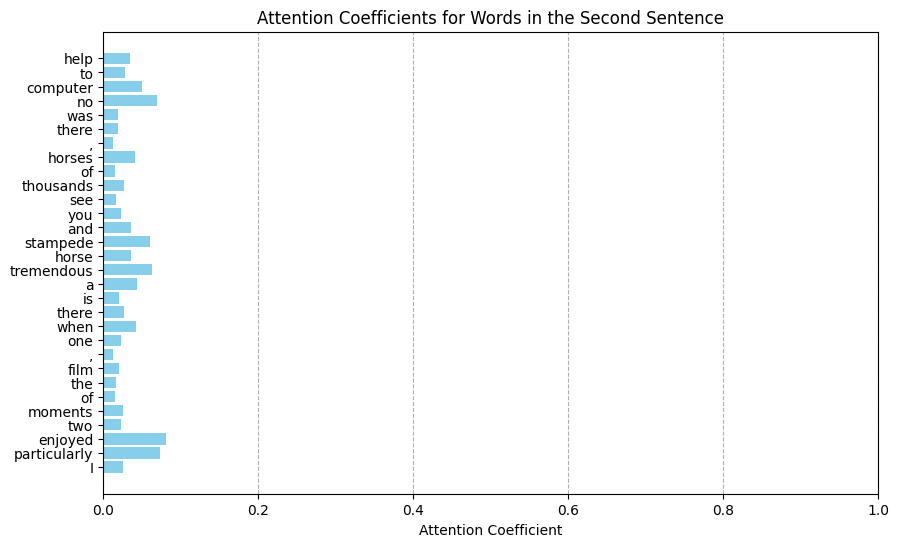

In [16]:
word_coeffs = word_att_coeffs
word_coeffs_list = word_coeffs.reshape(7, 30).tolist()

# match text and coefficients:
text_word_coeffs = [
    list(zip(words, word_coeffs_list[idx][: len(words)]))
    for idx, words in enumerate(my_review_text)
]
print(text_word_coeffs)

# get the second sentence and its corresponding coefficients:
second_sentence_coeffs = text_word_coeffs[-2]
print(second_sentence_coeffs)

# Plot the attention coefficients for the second sentence
attention_values = [elt[1] for elt in second_sentence_coeffs]
words = [elt[0] for elt in second_sentence_coeffs]

plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(words)), attention_values, align="center", color="skyblue")
plt.yticks(np.arange(len(words)), words)
plt.xlabel("Attention Coefficient")
plt.title("Attention Coefficients for Words in the Second Sentence")
plt.xlim(0, 1)  # Adjust x-axis limits for better visibility
plt.grid(axis="x", linestyle="--")
plt.show()